# Forecasting Carbon Dioxide trends in the atmosphere with SARIMA models.

In this notebook, I work out an exercise in analysing time series data. The data will be historical values of CO$_{2}$ concentration in the atmosphere provided by the <a href= "https://gml.noaa.gov/ccgg/trends/global.html"> NOAA </a>, my goal is to predict/forecast the CO$_{2}$ concentration at future dates. 

First load in necessary modules and dataset, when dealing with time series data, it is necessary to have the time component in datetime format and is often convenient to have this as the index, which I will do when reading in the data.

In [78]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [19]:
df=pd.read_csv('co2.csv',parse_dates=['date'],index_col='date')

In [10]:
df.head()

,CO2_ppm
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


<br>
The data gives the CO$_{2}$ concentration in the atmosphere in parts per million. The data is given in regular intervals of 1 month. Having a constant interval in time is extremeley convenient and in many cases, necessary to perform forecasting. Below I plot and examine the data.
<br>

<AxesSubplot:xlabel='date'>

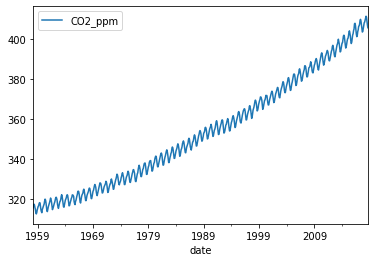

In [11]:
df.plot()

<AxesSubplot:xlabel='date'>

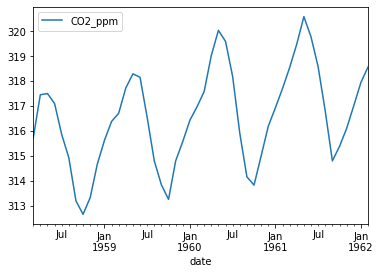

In [14]:
df.iloc[0:48].plot()

<br>
We see the overall trend of CO$_{2}$ concentration is increasing, but there is also a periodic variation in the data, this is called a seasonal variation. In the plot above I show a zoomed in portion of the timeseries and I can determine the seasonal variation to have a period of 12 months, which makes sense as energy consumption varies with the season.
We can decompose the seasonal variation and trend using seasonal_decompose.
<br>

In [25]:
decomp = seasonal_decompose(df['CO2_ppm'], 
                            period=12)

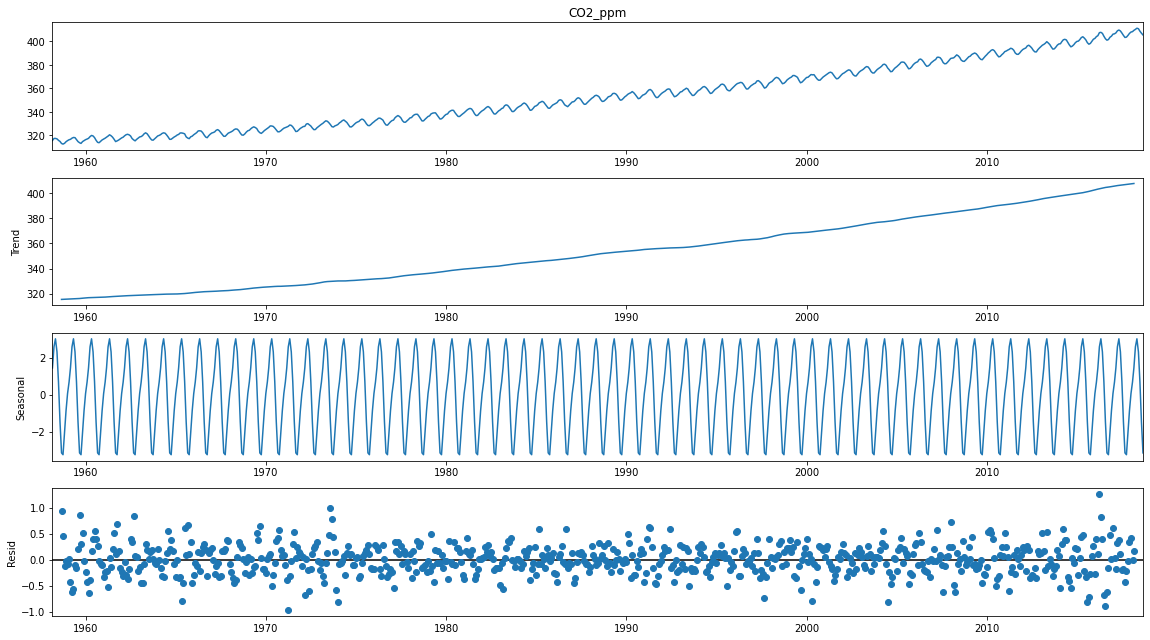

In [35]:
fig = decomp.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

<br>
The first plot shows the data, the second shows the trend without seasonal variation, the third plot shows the seasonal variation and the fourth plot shows the residual once seasonality and trend is subtracted from the data. The smooth trend, periodic seasonality and absence of correlation in the residue indicates that the seasonal variation indeed occurs over a timeframe of 12 months. 

However, we can be certain of this by looking at the autocorrelation function (ACF), which shows how strongly a data point at one time step correlates with data points at previous timesteps (or lags). To do this, I first de-trend the data (so the correlation is not affected by non-seasonal variations) by subtracting each data point by a rolling mean over a sufficiently large window.
<br>

In [39]:
df2 = df-df.rolling(15).mean()
df2=df2.dropna()

<AxesSubplot:xlabel='date'>

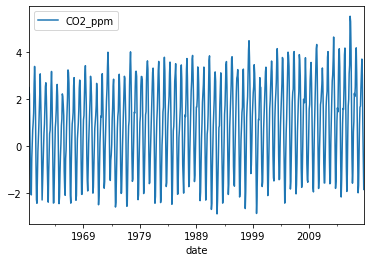

In [40]:
df2.plot()

<br>
The data now has no trend but retains its seasonality. Now I plot the ACF over 25 time steps.
<br>

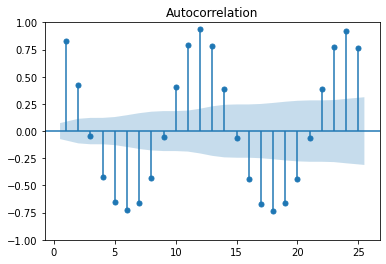

In [41]:
plot_acf(df2['CO2_ppm'], lags=25, zero=False)
plt.show()


<br>
We can see the ACF has a period of 12 time steps, now we have conclusive evidence to set this time window for seasonality.

I will use a seasonal autoregressive moving average model (or SARIMA model) to create a forecast for this time series. The important parameters needed for this model are the autoregressive (p), differencing (d) and moving average (q) orders for the non-seasonal and seasonal parts and the seasonal time window (which we know is 12). I will use P,D,Q for the seasonal orders and p,d,q for the non-season orders. These orders can be determined by fitting SARIMA models for various sets of orders and finding the best fit, however we can narrow down the range to search by inspecting the seasonal and non-seasonal ACFs and partial autocorrelation functions (PACFs). To do this we first need to subtract out the trend and seasonality from the timeseries data (need to make the data stationary).

To get rid of the trend I will perform a first order differencing, where each datapoint is subtracted by the data point at the previous timestep.
<br>

In [47]:
df3=df.diff().dropna()

<AxesSubplot:xlabel='date'>

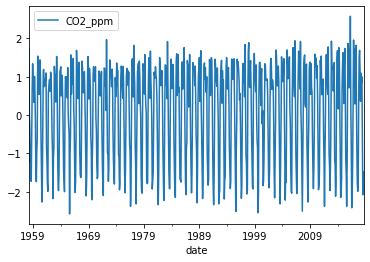

In [48]:
df3.plot()

<br>
From the plot we see the timeseries has no trend, but we can check this in a more statistically sound footing by performing an Augmented Dicky-Fuller test.
<br>

In [52]:
adtest = adfuller(df3['CO2_ppm'])

In [53]:
print('ADF Statistic:', adtest[0])
print('p-value:', adtest[1])

ADF Statistic: -5.287425631615341
p-value: 5.8137891753303364e-06


<br>
The negative ADF statistic indicates no trend, the p-value is for the null hypthesis that the data is non-stationary due to trends. The extremely low p-value suggest that we can reject the null hypothesis and conclude the data indeed has no trend. From this we can also obtain the differencing order (d) of the non-seasonal part as 1.

Now to 'de-seasonalize' the data I perform a difference over the seasonal time step (12 months)
<br>

In [56]:
df4=df3.diff(12).dropna()

<AxesSubplot:xlabel='date'>

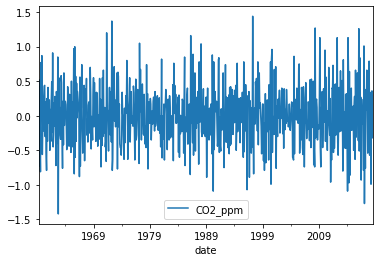

In [57]:
df4.plot()

<br>
The seasonal variations have now been erased out, we can proceed to plot the ACFs and PACFs.
First I plot the non-seasonal part below over 10 time lags.
<br>

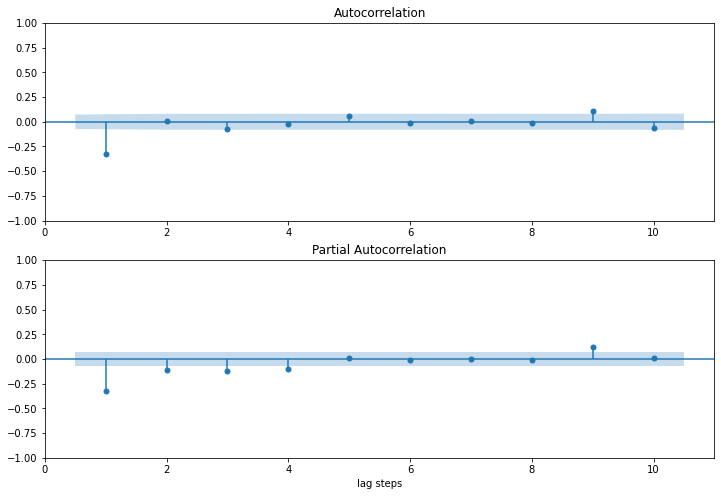

In [90]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(df4['CO2_ppm'], lags=10, zero=False,ax=ax1)
plot_pacf(df4['CO2_ppm'], lags=10, zero=False,method='ywm', ax=ax2)
plt.xlabel('lag steps')
plt.show()

<br>
The ACF (top plot) shows a sharp drop in the autocorrelation after 1 time lag, indicating the AR order p=1.
The PACF (bottom plot) indicates a sharp drop in the partial autocorrelation between 1-4 time lags indicating q is in the range 1-4.

Next I plot the seasonal ACFs and PACFs, for this I have to plot over the seasonal time lags which means every 12 time steps.
<br>

In [70]:
seasonal_lag=np.arange(12,73,12)

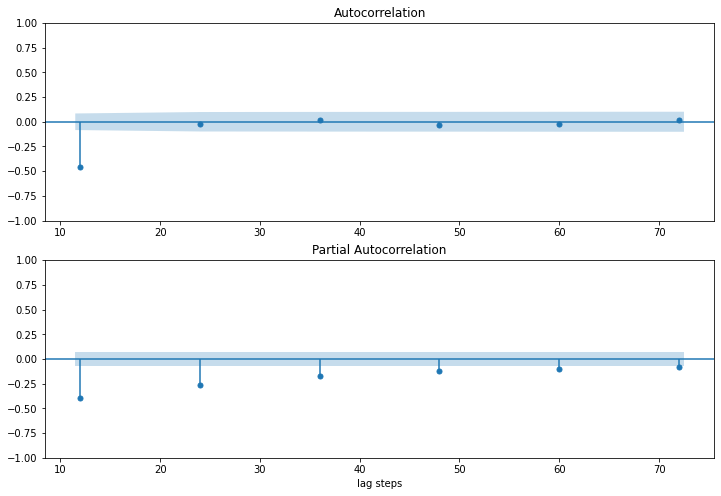

In [91]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(df4['CO2_ppm'], lags=seasonal_lag, zero=False,ax=ax1)
plot_pacf(df4['CO2_ppm'], lags=seasonal_lag, zero=False,method='ywm', ax=ax2)
plt.xlabel('lag steps')
plt.show()

<br>
The sharp drop in the ACF at time lag 1 indicates the seasonal AR order, P=1, and the gradual decline in the PACF indicates Q=0.

Now that I have a rough estimate for each of the parameters, I will fit a SARIMA model for each parameter set in this range and choose the best model based off the Akaike information criterion (AIC). I will use seasonal and non-seasonal differncing order (d,D) of 1, seasonal variation (m) of 12 time steps,  0$\le$ p,P,Q$\le$1, 1$\le$q$\le$4.
<br>

In [85]:
model= pm.auto_arima(df,
                      seasonal=True, m=12,
                      d=1, D=1, 
                      start_p=1, start_q=1,
                      max_p=1, max_q=4,
                      max_P=1, max_Q=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True, stepwise=False,n_jobs=3) 

 ARIMA(0,1,0)(1,1,0)[12]             : AIC=669.192, Time=0.39 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=571.558, Time=0.48 sec
 ARIMA(0,1,4)(0,1,0)[12]             : AIC=749.369, Time=0.25 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=393.821, Time=1.03 sec
 ARIMA(1,1,3)(0,1,0)[12]             : AIC=749.538, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=375.959, Time=1.51 sec
 ARIMA(0,1,3)(1,1,1)[12]             : AIC=375.496, Time=1.78 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=376.215, Time=2.03 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=844.086, Time=0.09 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=749.922, Time=0.32 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=377.294, Time=1.46 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=391.910, Time=1.08 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=377.383, Time=2.80 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(0,1,3)(0,1,1)[12]             : AIC=373.528, Time=1.66 sec
 ARIMA(1,1,1)(

In [86]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  727
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -181.764
Date:                              Wed, 20 Apr 2022   AIC                            373.528
Time:                                      16:59:01   BIC                            396.382
Sample:                                           0   HQIC                           382.354
                                              - 727                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3702      0.037    -10.118      0.000      -0.442      -0.298
ma.L2         -0.0242      0.038     -0.633      0.527      -0.099       0.051
ma.L3         -0.0749      0.036     -2.057      0.040      -0.146      -0.004
ma.S.L12      -0.8690      0.020    -42.542      0.000      -0.909      -0.829
sigma2         0.0951      0.005     20.464      0.000       0.086       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 4.52
Prob(Q):                              0.81   Prob(JB):                         0.10
Heteroskedasticity (H):               1.14   Skew:                             0.00
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<br>
We find the best model has (p,d,q)=(0,1,3) and (P,D,Q)=(0,1,1). The model summary shows various metrics and parametes, I will focus on the Prob(Q) and Prob(JB) parameters which are the p-values for the null hypothesis that the residual are not correlated and normally distributed respectively. A p-value larger than 0.05 indicates there is no significant evidence to reject the null hypothesis, and we can assume the residuals are normally and distributed and not correlated, which is required for a good forecasting model. These properties can also be inspected in visual form.
<br>

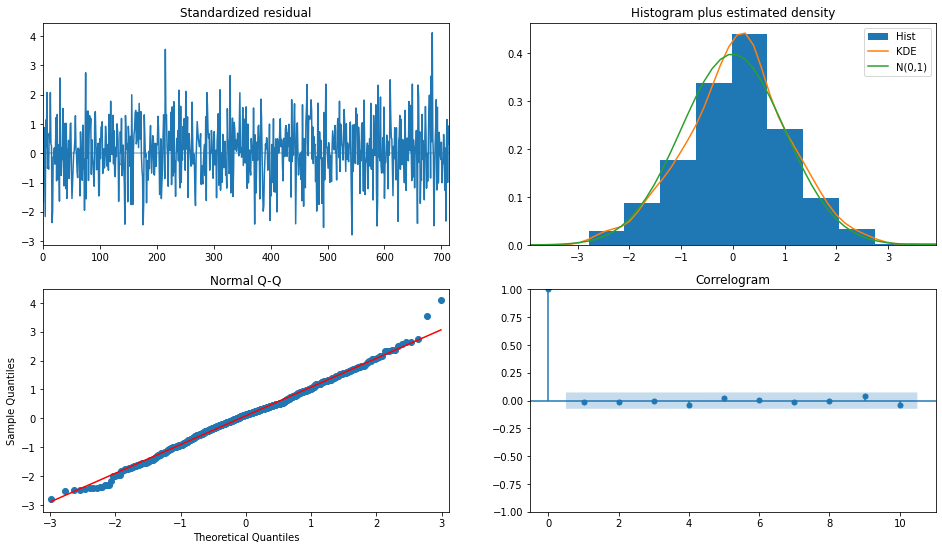

In [95]:
fig=model.plot_diagnostics()
fig.set_size_inches((16, 9))

plt.show()

<br>
The histogram shows the distribution of residuals (orange line) closely resemble that of a normal distribution (green line). In an ideal scenario, all the points would lie on the red diagonal line in the normal Q-Q plot indicating a perfect normal distribution, here the last two points stray away from the diagonal but this is not significant enough to assume non normal distribution. The correlogram indicates only the 0th term is strongly correlated indicating no correlation between the residuals.

Now that we have a sufficiently good model, I will fit a SARIMA model with a constant trend. I instantiate a model using the SARIMAX class, the X here stands for SARIMA models with exogenous variables, which we do not use.
<br>

In [99]:
model = SARIMAX(df, 
                order=(0,1,3), 
                seasonal_order=(0,1,1,12), 
                trend='c')
results = model.fit()

/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22697D-01    |proj g|=  9.35173D-01

At iterate    5    f=  2.72093D-01    |proj g|=  1.83946D-01

At iterate   10    f=  2.51820D-01    |proj g|=  8.29073D-01

At iterate   15    f=  2.46371D-01    |proj g|=  2.12206D-01

At iterate   20    f=  2.46072D-01    |proj g|=  1.62687D-01

At iterate   25    f=  2.44992D-01    |proj g|=  7.03253D-03

At iterate   30    f=  2.44977D-01    |proj g|=  3.71139D-02

At iterate   35    f=  2.44927D-01    |proj g|=  1.73511D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

<br>
I will now forecast the CO$_{2}$ concentration with the fit model for 120 time steps (10 years) in the future and include a 95% confidence interval for the forecast.
<br>

In [101]:
forecaster = results.get_forecast(steps=120)
mean = forecaster.predicted_mean
conf_int = forecaster.conf_int()
dates = mean.index

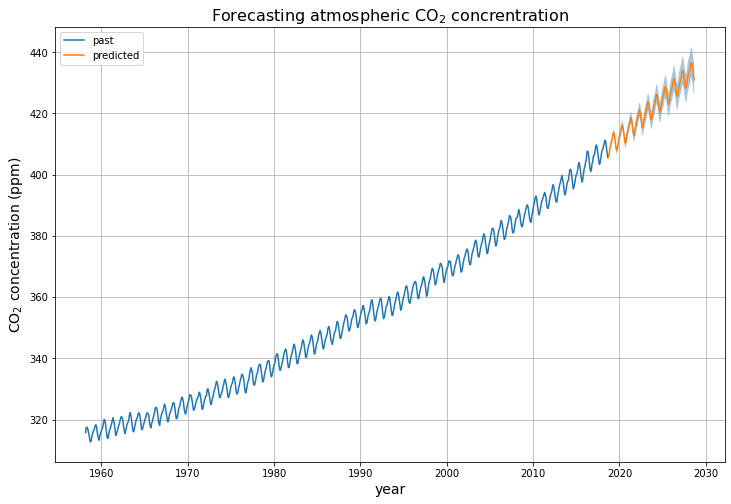

In [118]:
plt.figure(figsize=(12,8))
plt.plot(df.index, df['CO2_ppm'], label='past')
plt.plot(dates, mean, label='predicted')
plt.fill_between(dates, conf_int['lower CO2_ppm'], conf_int['upper CO2_ppm'], alpha=0.4)
plt.xlabel('year',fontsize=14)
plt.ylabel(r'CO$_{2}$ concentration (ppm)', fontsize=14)
plt.title(r'Forecasting atmospheric CO$_{2}$ concrentration', fontsize=16)
plt.legend()
plt.grid()
plt.show()

<br>
The CO$_{2}$ concentration keeps increasing, not a good sign in terms of climate impacts! We could have already said beforehand that the CO$_{2}$ concentration would keep increasing, but here we have a statistically ground model to show it and have quantified our uncertainty as well. With this we can make predictions on the actual values at various time steps more comfortably.